In [10]:
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# Load data
boston = datasets.load_boston()
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [3]:
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df = pd.concat([df,pd.Series(boston.target,name='MEDV')],axis=1)

In [4]:
import numpy as np

# It contains all attributes (all features and the target)
allData = df


# Use the following code to select ALL features
X = df.drop(columns='MEDV')  # Data Matrix containing all features excluding the target


y = df['MEDV'] # 1D targer vector

X = X.values
y = y.values

y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)

(506, 13)
(506, 1)


In [5]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

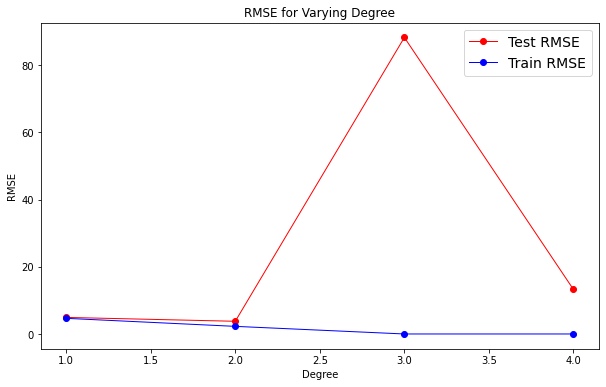


Optimal Degree:  2


In [7]:
degreeList = [1,2,3,4]

mse_train, mse_test = [], []

for degree in degreeList:

    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    model.fit(X_train, y_train)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    
    mse_train.append(mean_squared_error(y_train, y_train_predicted))
    mse_test.append(mean_squared_error(y_test, y_test_predicted))
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE") 
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of optimal degree for the polynomial that gives smallest RMSE

rmse_test = np.sqrt(mse_test)
j = 0
min_rmse = rmse_test[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_test[j] < min_rmse):
        min_rmse = rmse_test[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)


In [8]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)


print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

No. of Original Features:  13
No. of Augmented Features:  104


In [11]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

param_grid = {'alpha': np.linspace(0.01, 1.0, num=20), 
              'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga"]}

ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train_poly, y_train)


params_optimal_ridge = ridge_cv.best_params_

print("Best Score (negative mean squared error): %f" % ridge_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_ridge)
print("\n")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   15.4s


Best Score (negative mean squared error): -13.623137
Optimal Hyperparameter Values:  {'alpha': 0.16631578947368422, 'solver': 'saga'}


CPU times: user 1.03 s, sys: 129 ms, total: 1.16 s
Wall time: 16.4 s


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   16.3s finished


In [12]:
# Ridge Regression


# Optimal model parameters
ridge_alpha = ridge_cv.best_params_['alpha']
print("Optimal alpha: ", ridge_alpha)

ridge_solver = ridge_cv.best_params_['solver']
print("Optimal alpha: ", ridge_solver)


# Create Ridge linear regression object
lin_reg_ridge = Ridge(alpha=ridge_alpha, solver=ridge_solver)

# Train the model
lin_reg_ridge.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_ridge = lin_reg_ridge.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_ridge))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_ridge))

Optimal alpha:  0.16631578947368422
Optimal alpha:  saga

----------------------------- Model Evaluation -----------------------------

Mean squared error: 8.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.90


In [13]:

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_ridge.predict(X_test_poly)


ridge_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % ridge_test_mse)



ridge_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % ridge_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 12.91
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82


In [14]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

In [15]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

#param_grid = {'alpha': np.linspace(10.0, 20.0, num=10)}
param_grid = {'alpha': np.linspace(10.0, 20.0)}

lasso = Lasso()

lasso_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train_poly, y_train)

params_optimal_lasso = lasso_cv.best_params_

print("Best Score (negative mean squared error): %f" % lasso_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_lasso)
print("\n")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:    0.5s


Best Score (negative mean squared error): -12.188291
Optimal Hyperparameter Values:  {'alpha': 15.510204081632654}


CPU times: user 410 ms, sys: 39.3 ms, total: 449 ms
Wall time: 852 ms


[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [16]:
# Lasso Regression

# Optimal model parameters
lasso_alpha = lasso_cv.best_params_['alpha']
print("Optimal alpha: ", lasso_alpha)


# Create Lasso linear regression object
lin_reg_lasso = Ridge(alpha=lasso_alpha)

# Train the model
lin_reg_lasso.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_lasso = lin_reg_lasso.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_lasso))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_lasso))

Optimal alpha:  15.510204081632654

----------------------------- Model Evaluation -----------------------------

Mean squared error: 6.57
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.92


In [17]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_lasso.predict(X_test_poly)

lasso_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % lasso_test_mse)


# Explained variance score: 1 is perfect prediction

lasso_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % lasso_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 13.29
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82


In [18]:
print("%8s (alpha = %3.3f)  %10s (alpha = %3.3f)" % ("Ridge",ridge_alpha, "Lasso", lasso_alpha))
print("%2s Test MSE = %3.3f  %8s Test MSE = %3.3f" % (" ",ridge_test_mse, " ", lasso_test_mse))
print("%2s Test R2 Score = %3.3f  %4s Test R2 Score = %3.3f" % (" ",ridge_test_r2_score, " ", lasso_test_r2_score))
print("________________________________________________________________\n")
for i in range(lin_reg_ridge.coef_.shape[0]):
    print("%15f  %30f" % (lin_reg_ridge.coef_[i], lin_reg_lasso.coef_[i]))

   Ridge (alpha = 0.166)       Lasso (alpha = 15.510)
   Test MSE = 12.907           Test MSE = 13.292
   Test R2 Score = 0.824       Test R2 Score = 0.819
________________________________________________________________



TypeError: only size-1 arrays can be converted to Python scalars